In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.data.load_fraud_data import load_fraud_data
from uais.features.fraud_features import build_fraud_feature_table
from sklearn.model_selection import train_test_split


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [2]:
df_raw = load_fraud_data()
df_feats = build_fraud_feature_table(df_raw, 'Time', 'Amount', 'Class')

target_col = 'Class'
X = df_feats.drop(columns=[target_col])
y = df_feats[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (5317941, 43) Test: (1329486, 43)


In [3]:
drift_results = []

for col in X_train.columns:
    train_vals = X_train[col].values
    test_vals = X_test[col].values

    if np.issubdtype(train_vals.dtype, np.number):
        stat, pval = ks_2samp(train_vals, test_vals)
        drift_results.append((col, stat, pval))

drift_df = pd.DataFrame(drift_results, columns=['feature', 'ks_stat', 'p_value'])
drift_df.sort_values('p_value', inplace=True)

drift_df.head(20)


,feature,ks_stat,p_value
1,Amount,0.000673,0.721007
36,amount_log,0.000673,0.721007
37,time_hours,0.000222,1.000000
38,time_seconds_mod_day,0.000173,1.000000
39,hour_of_day,0.000146,1.000000
0,step,NaN,NaN
2,oldbalanceorg,NaN,NaN
3,newbalanceorig,NaN,NaN
4,oldbalancedest,NaN,NaN
5,newbalancedest,NaN,NaN


Top drifting features: ['Amount', 'amount_log', 'time_hours', 'time_seconds_mod_day', 'hour_of_day']


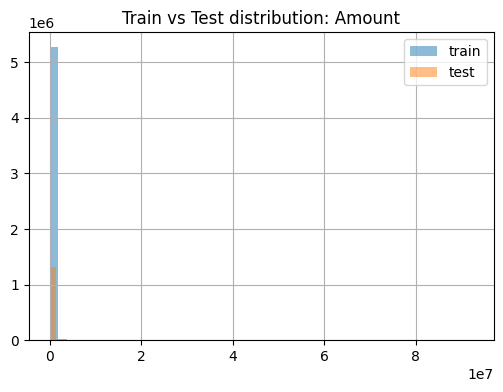

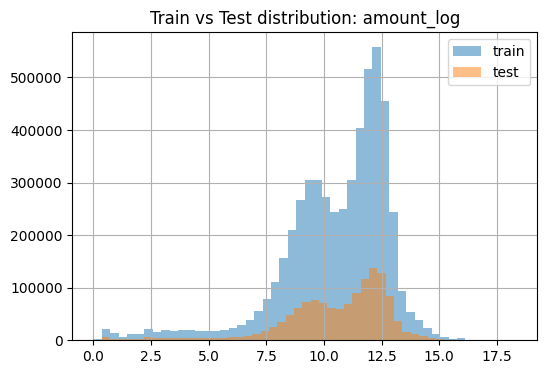

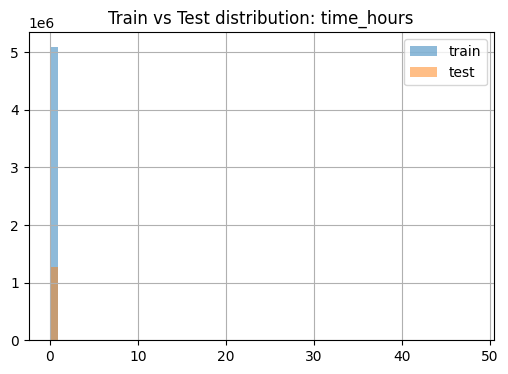

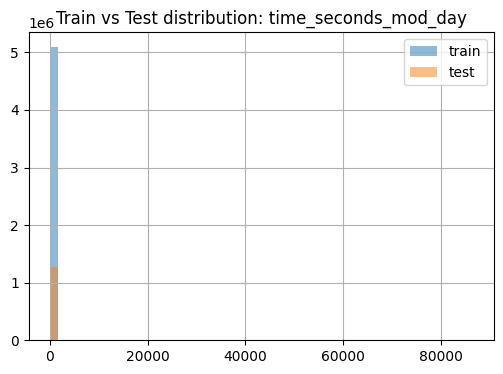

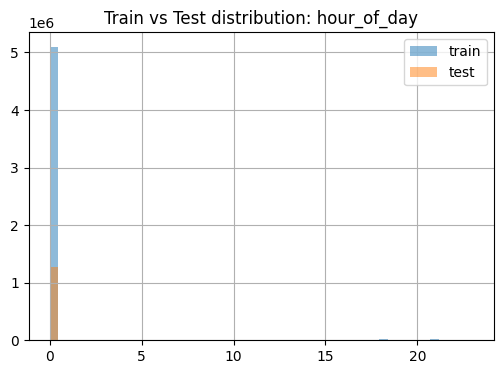

In [4]:
top_drifting = drift_df.head(5)['feature'].tolist()
print('Top drifting features:', top_drifting)

for col in top_drifting:
    plt.figure(figsize=(6, 4))
    X_train[col].hist(alpha=0.5, label='train', bins=50)
    X_test[col].hist(alpha=0.5, label='test', bins=50)
    plt.title(f'Train vs Test distribution: {col}')
    plt.legend()
    plt.show()
